<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Baseline_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SETUP

In [ ]:
#import os
#import tensorflow as tf
#import numpy as np
#import random as rn

#os.environ['PYTHONHASHSEED'] = '0'
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
#np.random.seed(37)
#tf.random.set_seed(89)

#import numpy as np
#import os
#import random
#import tensorflow as tf # 2.2.0

#SEED = 42
#os.environ['PYTHONHASHSEED']=str(SEED)
#os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1+
#np.random.seed(SEED)
#random.seed(SEED)
#tf.random.set_seed(SEED)

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.utils import np_utils
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import random
import itertools
random.seed(10)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# DATA PROCESSING

In [5]:
train_dir = '/content/drive/My Drive/Colab Notebooks/charts/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/charts/Validation'

In [6]:
img_width, img_height = 224, 224 
nb_train_samples = 560
nb_validation_samples = 140
epochs = 100
batch_size = 16

In [7]:
#checking whether the rgb channel is first or last to feed the input shape accordingly
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [ ]:
#Experimental block of code for hsv - has issues with range (0-255) which will not produce efficient training
#import cv2
#import numpy as np
#from PIL import Image
#def myFunc(image):
 #   image = np.array(image)
  #  hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
   # hsv_image = hsv_image.astype('float32')
    #hsv_image = hsv_image / 255.0
    #return Image.fromarray(hsv_image)

In [8]:
# Inspired by random crop functionality from https://jkjung-avt.github.io/keras-image-cropping/
def noisy_generator(batches):
    for batch_x, batch_y in batches:
        sigma = np.random.exponential(0.15)
        #noise_factor = 0.1
        noise = np.random.normal(0.0, scale=sigma, size=batch_x.shape)
        #noise = np.random.normal(0, 0.1, batch_x.shape)
        batch_noisy = np.clip(batch_x + noise, 0, 1)
        yield (batch_noisy, batch_y)

In [10]:
#Performing augmentation on image scaling, zoom and flipping so that the network has more training samples
train_datagen = ImageDataGenerator( 
	rescale=1. / 255, 
	shear_range=0.2, 
	zoom_range=0.2,
	brightness_range=(0.6,0.9) #Range starts from 0.6 as I do not expect very dark chart image inputs
	) 

#Not having any augmentation apart from scaling as the validation data should resemble the real-world data as close as possible
val_datagen = ImageDataGenerator(rescale=1. / 255) 

test_datagen = ImageDataGenerator(rescale=1. /255)

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size,
	class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size,
	class_mode='categorical')

test_generator = val_datagen.flow_from_directory(
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size,
	class_mode='categorical',
	shuffle=False
)

#Adding noise
train_noisy = noisy_generator(train_generator)

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [11]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

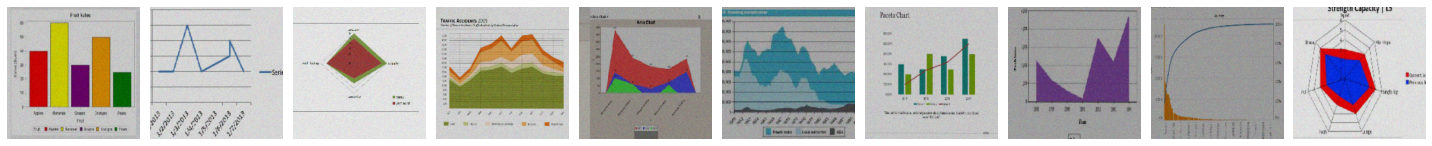

In [12]:
sample_training_images, _ = next(train_noisy)
plotImages(sample_training_images[:10])

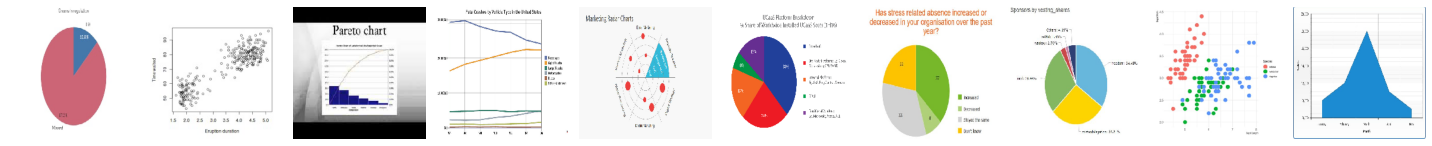

In [13]:
sample_val_images, _ = next(validation_generator)
plotImages(sample_val_images[:10])

#BASELINE CNN MODEL

In [ ]:
# 3 CNN blocks containing a max pooling layer in each of them. On top of that is a fully connected layer with relu activation function
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])


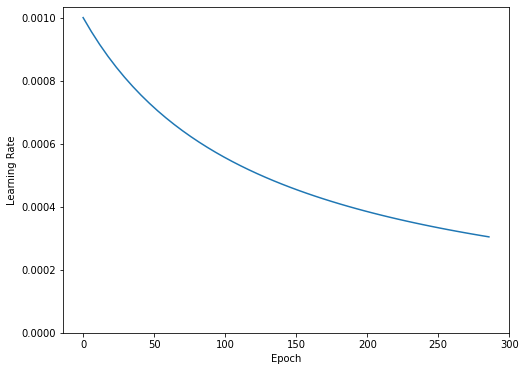

In [ ]:
STEPS_PER_EPOCH = nb_train_samples // batch_size

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=8,
  staircase=False)

step = np.linspace(0,10000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule) ,
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)            

In [ ]:
#Since data aug is applied only to training and not on validation set, there might be epochs where the validation accuracy will be greater than
#the training accuracy in the initial few epochs
history = model.fit( 
	train_noisy, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=300, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 1/300
35/35 [==============================] - 18s 502ms/step - loss: 2.6346 - accuracy: 0.2232 - val_loss: 1.5802 - val_accuracy: 0.3750
Epoch 2/300
35/35 [==============================] - 17s 479ms/step - loss: 1.4444 - accuracy: 0.4000 - val_loss: 1.2870 - val_accuracy: 0.5078
Epoch 3/300
35/35 [==============================] - 17s 484ms/step - loss: 1.2419 - accuracy: 0.4839 - val_loss: 1.2570 - val_accuracy: 0.4844
Epoch 4/300
35/35 [==============================] - 16s 470ms/step - loss: 1.1490 - accuracy: 0.5000 - val_loss: 1.1816 - val_accuracy: 0.5312
Epoch 5/300
35/35 [==============================] - 17s 483ms/step - loss: 0.9365 - accuracy: 0.6161 - val_loss: 1.2430 - val_accuracy: 0.5469
Epoch 6/300
35/35 [==============================] - 17s 476ms/step - loss: 0.9159 - accuracy: 0.6161 - val_loss: 1.4213 - val_accuracy: 0.5469
Epoch 7/300
35/35 [==============================] - 17s 483ms/step - loss: 0.9217 - accuracy: 0.6286 - val_loss: 1.2715 - val_accuracy:

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks', save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/assets


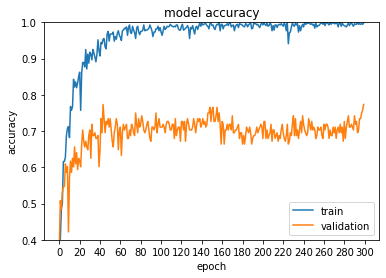

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,320, 20))
plt.ylim(0.4,1.0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

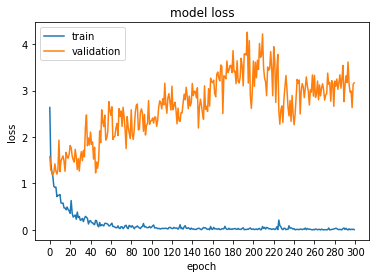

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,320, 20))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
load = keras.models.load_model('/content/drive/My Drive/Colab Notebooks')

In [15]:
y_pred = load.predict(test_generator)

In [16]:
y_prediction = np.argmax(y_pred , axis=1)

In [17]:
conf_matrix=confusion_matrix(test_generator.classes, y_prediction)

In [18]:
target_names = ['AreaChart', 'BarChart', 'LineChart', 'ParetoChart', 'PieChart', 'RadarChart', 'ScatterPlot']

In [19]:
#Confusion matrix plotting function taken from https://sites.google.com/view/amarnath-r/keras-deep-learning-image-classification-a-simple-example
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)

Normalized confusion matrix
[[0.85 0.05 0.05 0.   0.05 0.   0.  ]
 [0.1  0.75 0.05 0.05 0.05 0.   0.  ]
 [0.   0.   0.85 0.   0.   0.   0.15]
 [0.   0.   0.05 0.9  0.05 0.   0.  ]
 [0.   0.1  0.   0.   0.9  0.   0.  ]
 [0.   0.   0.35 0.   0.1  0.5  0.05]
 [0.   0.05 0.35 0.   0.   0.   0.6 ]]


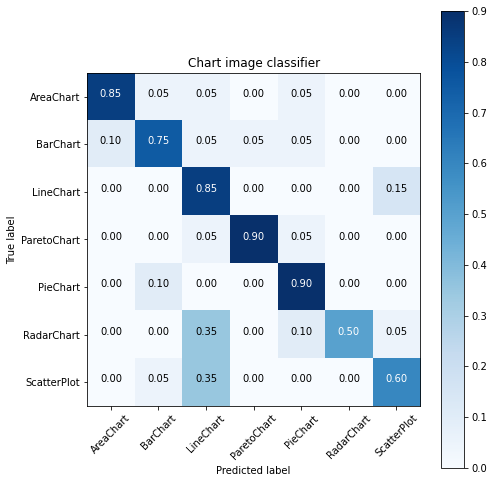

In [20]:
final_confusion_matrix = plt.figure(figsize=(7, 7))
plot_confusion_matrix(conf_matrix, classes=target_names, normalize=True, title='Chart image classifier')

In [21]:
print(classification_report(test_generator.classes, y_prediction, target_names=target_names))

              precision    recall  f1-score   support

   AreaChart       0.89      0.85      0.87        20
    BarChart       0.79      0.75      0.77        20
   LineChart       0.50      0.85      0.63        20
 ParetoChart       0.95      0.90      0.92        20
    PieChart       0.78      0.90      0.84        20
  RadarChart       1.00      0.50      0.67        20
 ScatterPlot       0.75      0.60      0.67        20

    accuracy                           0.76       140
   macro avg       0.81      0.76      0.77       140
weighted avg       0.81      0.76      0.77       140



#ABLATION STUDY

# <H4>Remove data augementation, gaussian noise and learning rate scheduling - keep all classes

In [ ]:
train_datagen_2 = ImageDataGenerator(rescale=1. /255)
val_datagen_2 = ImageDataGenerator(rescale=1. / 255) 

train_generator_2 = train_datagen_2.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator_2 = val_datagen_2.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


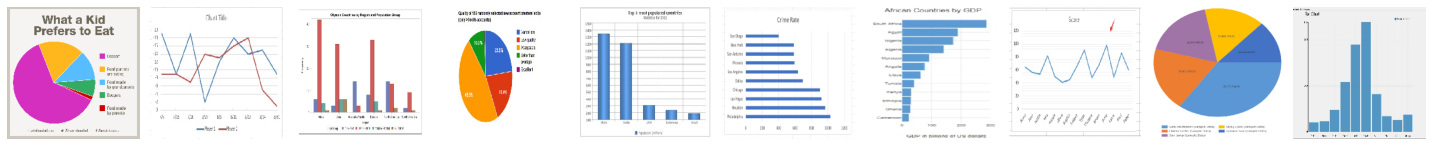

In [ ]:
sample_training_images, _ = next(train_generator_2)
plotImages(sample_training_images[:10])

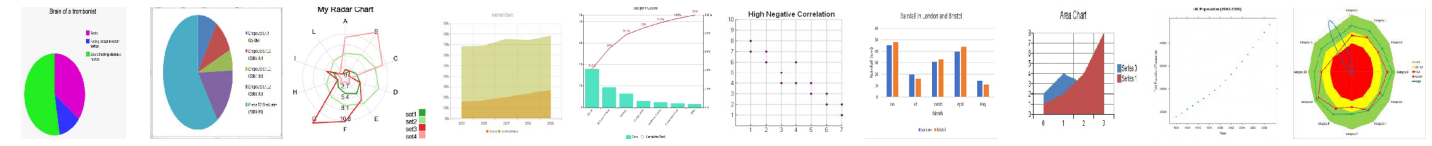

In [ ]:
sample_training_images, _ = next(validation_generator_2)
plotImages(sample_training_images[:10])

In [ ]:
model_repeat = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [ ]:
lr=0.001
model_repeat.compile(optimizer=keras.optimizers.Adam(lr) ,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

In [ ]:
#Since data aug is applied only to training and not on validation set, there might be epochs where the validation accuracy will be greater than
#the training accuracy in the initial few epochs
history2 = model_repeat.fit( 
	train_generator_2, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator_2, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 1/100
35/35 [==============================] - 238s 7s/step - loss: 2.8253 - accuracy: 0.2375 - val_loss: 1.6212 - val_accuracy: 0.5234
Epoch 2/100
35/35 [==============================] - 5s 154ms/step - loss: 1.1981 - accuracy: 0.5893 - val_loss: 1.2395 - val_accuracy: 0.6094
Epoch 3/100
35/35 [==============================] - 5s 154ms/step - loss: 0.6530 - accuracy: 0.7607 - val_loss: 0.9644 - val_accuracy: 0.6719
Epoch 4/100
35/35 [==============================] - 5s 154ms/step - loss: 0.2820 - accuracy: 0.9232 - val_loss: 1.0373 - val_accuracy: 0.7422
Epoch 5/100
35/35 [==============================] - 5s 156ms/step - loss: 0.1476 - accuracy: 0.9607 - val_loss: 1.4572 - val_accuracy: 0.7344
Epoch 6/100
35/35 [==============================] - 5s 152ms/step - loss: 0.0664 - accuracy: 0.9857 - val_loss: 1.1374 - val_accuracy: 0.7656
Epoch 7/100
35/35 [==============================] - 6s 163ms/step - loss: 0.0442 - accuracy: 0.9893 - val_loss: 1.2665 - val_accuracy: 0.7578


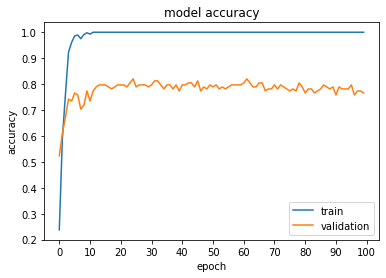

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

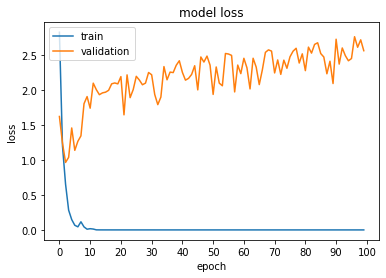

In [ ]:
# summarize history for loss https://www.kaggle.com/prateek0x/multiclass-image-classification-using-keras
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,110, 10))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# <H4> Remove gaussian noise and learning rate - keep data augmentation and all classes

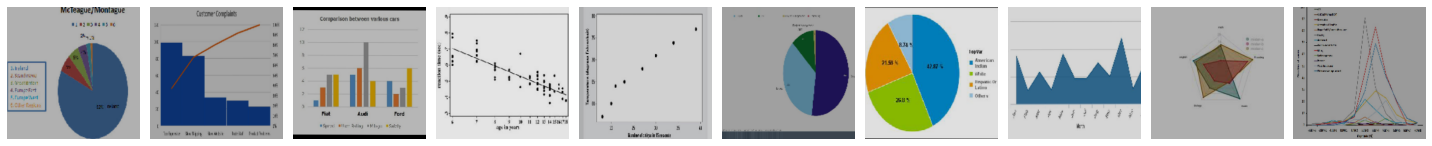

In [ ]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:10])

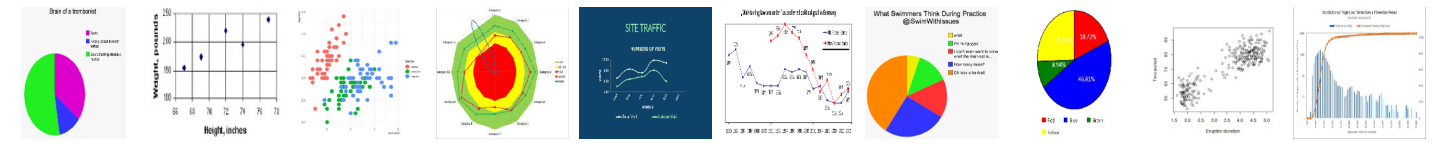

In [ ]:
sample_val_images, _ = next(validation_generator)
plotImages(sample_val_images[:10])

In [ ]:
model_repeat_3 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [ ]:
lr=0.001
model_repeat_3.compile(optimizer=keras.optimizers.Adam(lr) ,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)            

In [ ]:
history3 = model_repeat_3.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/100
35/35 [==============================] - 11s 316ms/step - loss: 2.6661 - accuracy: 0.2536 - val_loss: 1.5953 - val_accuracy: 0.3047
Epoch 2/100
35/35 [==============================] - 11s 312ms/step - loss: 1.2624 - accuracy: 0.5143 - val_loss: 1.2613 - val_accuracy: 0.5469
Epoch 3/100
35/35 [==============================] - 11s 309ms/step - loss: 0.9389 - accuracy: 0.6411 - val_loss: 1.1413 - val_accuracy: 0.6719
Epoch 4/100
35/35 [==============================] - 11s 306ms/step - loss: 0.7861 - accuracy: 0.6982 - val_loss: 1.1351 - val_accuracy: 0.6016
Epoch 5/100
35/35 [==============================] - 11s 307ms/step - loss: 0.7183 - accuracy: 0.7429 - val_loss: 1.3965 - val_accuracy: 0.6719
Epoch 6/100
35/35 [==============================] - 11s 308ms/step - loss: 0.6232 - accuracy: 0.7821 - val_loss: 1.2095 - val_accuracy: 0.7266
Epoch 7/100
35/35 [==============================] - 11s 305ms/step - loss: 0.4284 - accuracy: 0.8375 - val_loss: 1.4744 - val_accuracy:

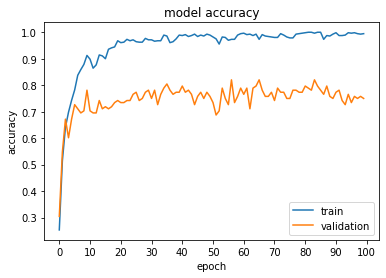

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

#<H4>Remove gaussian noise - keep learning rate scheduling, data augmentation and all classes

In [ ]:
model_repeat_4 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [ ]:
model_repeat_4.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule) ,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat_4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)            

In [ ]:
history4 = model_repeat_4.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/100
35/35 [==============================] - 11s 312ms/step - loss: 1.7963 - accuracy: 0.3625 - val_loss: 1.4618 - val_accuracy: 0.5625
Epoch 2/100
35/35 [==============================] - 11s 304ms/step - loss: 1.0366 - accuracy: 0.6036 - val_loss: 1.2424 - val_accuracy: 0.6094
Epoch 3/100
35/35 [==============================] - 11s 304ms/step - loss: 0.8286 - accuracy: 0.7125 - val_loss: 1.3116 - val_accuracy: 0.6484
Epoch 4/100
35/35 [==============================] - 11s 304ms/step - loss: 0.7416 - accuracy: 0.7714 - val_loss: 1.3248 - val_accuracy: 0.6641
Epoch 5/100
35/35 [==============================] - 11s 305ms/step - loss: 0.5331 - accuracy: 0.8304 - val_loss: 1.2309 - val_accuracy: 0.6719
Epoch 6/100
35/35 [==============================] - 11s 305ms/step - loss: 0.4383 - accuracy: 0.8571 - val_loss: 1.3374 - val_accuracy: 0.6875
Epoch 7/100
35/35 [==============================] - 11s 306ms/step - loss: 0.4031 - accuracy: 0.8679 - val_loss: 1.3398 - val_accuracy:

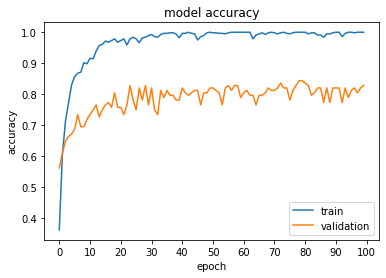

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

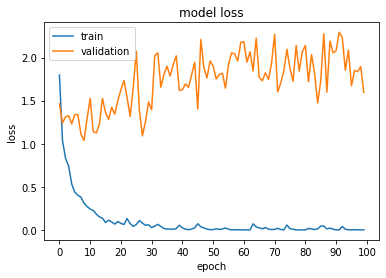

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,110, 10))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#<H4>Keep gaussian noise, learning rate scheduling & data aug - remove pareto chart and radar chart classes (only 5 charts)

In [ ]:
train_generator_5 = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical',
  classes=["AreaChart", "BarChart", "LineChart", "PieChart", "ScatterPlot"]) 

validation_generator_5 = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical', 
  classes=["AreaChart", "BarChart", "LineChart", "PieChart", "ScatterPlot"])

#Adding noise
train_noisy_5 = noisy_generator(train_generator_5)

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [ ]:
model_repeat_5 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [ ]:
model_repeat_5.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule) ,
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat_5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 50176)            

In [ ]:
train_samples = 400
val_samples = 100

In [ ]:
history5 = model_repeat_5.fit( 
	train_noisy_5, 
	steps_per_epoch=train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator_5, 
	validation_steps= val_samples // batch_size)

Epoch 1/100
25/25 [==============================] - 10s 417ms/step - loss: 3.6292 - accuracy: 0.2075 - val_loss: 1.5981 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 10s 410ms/step - loss: 1.4734 - accuracy: 0.3850 - val_loss: 1.4798 - val_accuracy: 0.3646
Epoch 3/100
25/25 [==============================] - 10s 415ms/step - loss: 1.1607 - accuracy: 0.4900 - val_loss: 1.0515 - val_accuracy: 0.5729
Epoch 4/100
25/25 [==============================] - 10s 412ms/step - loss: 0.9201 - accuracy: 0.5500 - val_loss: 1.0806 - val_accuracy: 0.4479
Epoch 5/100
25/25 [==============================] - 10s 412ms/step - loss: 0.8796 - accuracy: 0.5600 - val_loss: 1.0981 - val_accuracy: 0.6250
Epoch 6/100
25/25 [==============================] - 11s 426ms/step - loss: 0.7187 - accuracy: 0.6650 - val_loss: 1.0801 - val_accuracy: 0.6146
Epoch 7/100
25/25 [==============================] - 11s 422ms/step - loss: 0.7458 - accuracy: 0.6500 - val_loss: 0.9451 - val_accuracy:

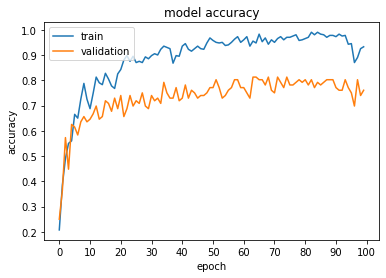

In [ ]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()